In [1]:
from enum import Enum, auto
import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg
from typing import Tuple

In [2]:
# helper function
def vis_matrix(M, cmap=plt.cm.Blues):
    fig, ax = plt.subplots()
    ax.matshow(M, cmap=cmap)
    for i in range(M.shape[0]):
        for j in range(M.shape[1]):
            c = M[j, i]
            ax.text(i, j, "%.2f" % c, va="center", ha="center")

In [3]:
# Define the actions
class Action(Enum):
    UP = auto()
    DOWN = auto()
    LEFT = auto()
    RIGHT = auto()


# Agent Policy, random
class Policy:
    def __init__(self):
        self._possible_actions = [action for action in Action]
        self._action_probs = {
            a: 1 / len(self._possible_actions) for a in self._possible_actions
        }

    def __call__(self, state: Tuple[int, int], action: Action) -> float:
        """
        Returns the action probability
        """
        assert action in self._possible_actions
        # state is unused for this policy
        return self._action_probs[action]

In [4]:
class Environment:
    def __init__(self):
        self.grid_width = 5
        self.grid_height = 5
        self._good_state1 = (0, 1)
        self._good_state2 = (0, 3)
        self._to_state1 = (4, 2)
        self._to_state2 = (2, 3)
        self._bad_state1 = (1, 1)
        self._bad_state2 = (4, 4)
        self._bad_states = [self._bad_state1, self._bad_state2]
        self._good_states = [self._good_state1, self._good_state2]
        self._to_states = [self._to_state1, self._to_state2]
        self._good_rewards = [10, 5]

    def step(self, state, action):
        i, j = state
        for good_state, reward, to_state in zip(
            self._good_states, self._good_rewards, self._to_states
        ):
            if (i, j) == good_state:
                return (to_state, reward)
        reward = 0
        if state in self._bad_states:
            reward = -1
        if action == Action.LEFT:
            j_next = max(j - 1, 0)
            i_next = i
            if j - 1 < 0:
                reward = -1
        elif action == Action.RIGHT:
            j_next = min(j + 1, self.grid_width - 1)
            i_next = i
            if j + 1 > self.grid_width - 1:
                reward = -1
        elif action == Action.UP:
            j_next = j
            i_next = max(i - 1, 0)
            if i - 1 < 0:
                reward = -1
        elif action == Action.DOWN:
            j_next = j
            i_next = min(i + 1, self.grid_height - 1)
            if i + 1 > self.grid_height - 1:
                reward = -1
        else:
            raise ValueError("Invalid action")
        return ((i_next, j_next), reward)

In [5]:
pi = Policy()
env = Environment()

# setup probability matrix and reward matrix
P = np.zeros((env.grid_width * env.grid_height, env.grid_width * env.grid_height))
R = np.zeros_like(P)
possible_actions = [action for action in Action]

# Loop for all states and fill up P and R
for i in range(env.grid_height):
    for j in range(env.grid_width):
        state = (i, j)
        # loop for all action and setup P and R
        for action in possible_actions:
            next_state, reward = env.step(state, action)
            (i_next, j_next) = next_state
            P[i * env.grid_width + j, i_next * env.grid_width + j_next] += pi(
                state, action
            )
            # the reward depends only on the starting state and the final state
            R[i * env.grid_width + j, i_next * env.grid_width + j_next] = reward

In [6]:
# check the correctness
assert((np.sum(P, axis=1) == 1).all())

In [7]:
# expected reward for each state
R_expected = np.sum(P * R, axis=1, keepdims=True)

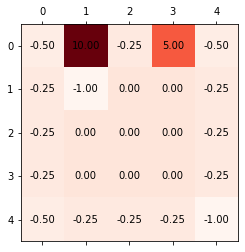

In [8]:
# reshape the state values in a matrix
R_square = R_expected.reshape((env.grid_height,env.grid_width))
# Visualize
vis_matrix(R_square, cmap=plt.cm.Reds)

In [9]:
# define the discount factor
gamma = 0.9

In [10]:
# Now it is possible to solve the Bellman Equation
A = np.eye(env.grid_width*env.grid_height) - gamma * P
B = R_expected

In [11]:
# solve using scipy linalg
V = linalg.solve(A, B)

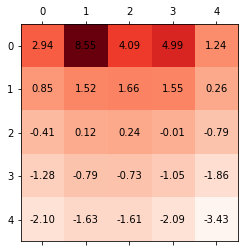

In [12]:
# reshape the state values in a matrix
V_square = V.reshape((env.grid_height,env.grid_width))
# visualize results
vis_matrix(V_square, cmap=plt.cm.Reds)